In [2]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random

100%|██████████| 26421880/26421880 [00:02<00:00, 11911975.56it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 199578.71it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3706028.79it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8558175.58it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



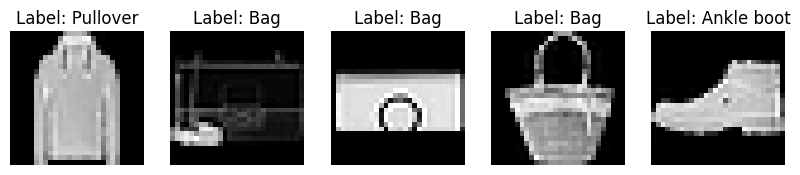

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 64
learning_rate = 0.001
num_epochs = 10
latent_dim = 64
lamb = 5  # Increased regularization weight

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load FashionMNIST dataset
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
class_names = train_dataset.classes

# Visualize sample images
sample_batch, sample_labels = next(iter(train_loader))
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(sample_batch[i].squeeze().numpy(), cmap='gray')
    plt.title(f"Label: {class_names[sample_labels[i]]}")
    plt.axis('off')
plt.show()

In [4]:
def vae_loss_function(recon_x, x, x_masked, mu, logvar, lamb=lamb):
    MSE_masked = nn.functional.mse_loss(recon_x, x_masked.view(-1, 784), reduction="sum")
    MSE = nn.functional.mse_loss(recon_x, x.view(-1, 784), reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE_masked + MSE + lamb * KLD

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.BatchNorm1d(256),  # Batch normalization
            nn.LeakyReLU(0.2),     # Leaky ReLU
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),   # Batch normalization
            nn.LeakyReLU(0.2),     # Leaky ReLU
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),    # Batch normalization
            nn.LeakyReLU(0.2)      # Leaky ReLU
        )
        self.mu = nn.Linear(64, latent_dim)
        self.log_var = nn.Linear(64, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.BatchNorm1d(64),    # Batch normalization
            nn.LeakyReLU(0.2),     # Leaky ReLU
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),   # Batch normalization
            nn.LeakyReLU(0.2),     # Leaky ReLU
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),   # Batch normalization
            nn.LeakyReLU(0.2),     # Leaky ReLU
            nn.Linear(256, 28*28),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.encoder(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decoder(z)
        return x_recon, mu, log_var

In [5]:
def create_mask(batch_size, images):
    mask_size = 8
    mask = torch.ones((batch_size, 1, 28, 28)).to(device)
    masked_images = images.clone()
    for i in range(batch_size):
        image_height, image_width = images.size()[2:]  # Get the height and width of the image
        top = random.randint(0, image_height - mask_size)  # Adjusted to fit within image dimensions
        left = random.randint(0, image_width - mask_size)  # Adjusted to fit within image dimensions
        # Apply the mask
        masked_images[i, :, top:top+mask_size, left:left+mask_size] = 0
    return masked_images

In [6]:
# Initialize VAE model, loss function, and optimizer
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        images, _ = data
        images = images.to(device)

        # Create masked images
        masked_images = create_mask(images.size(0), images)

        # Forward pass
        recon_images, mu, log_var = model(masked_images)

        # Compute the loss
        loss = vae_loss_function(recon_images, images, masked_images, mu, log_var)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

print('Finished Training')

Epoch 1/10, Loss: 64318.5422
Epoch 2/10, Loss: 62012.7503
Epoch 3/10, Loss: 61769.0153
Epoch 4/10, Loss: 61677.2370
Epoch 5/10, Loss: 61580.2809
Epoch 6/10, Loss: 61494.4216
Epoch 7/10, Loss: 61416.8354
Epoch 8/10, Loss: 61363.4261
Epoch 9/10, Loss: 61331.4069
Epoch 10/10, Loss: 61289.3007
Finished Training


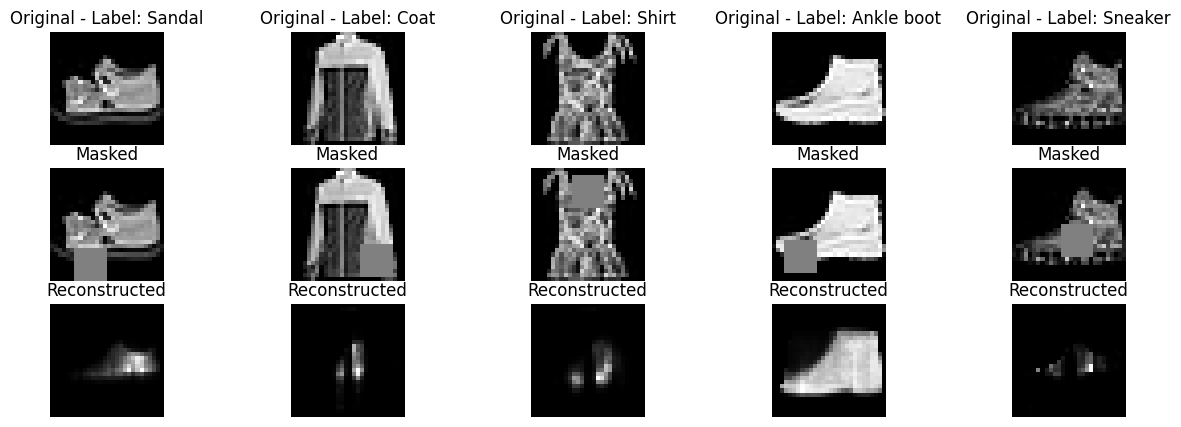

In [7]:
# Visualization
sample_batch, _ = next(iter(train_loader))

# Original Images
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(3, 5, i+1)
    plt.imshow(sample_batch[i].squeeze().numpy(), cmap='gray')
    plt.title(f"Original - Label: {class_names[_[i]]}")
    plt.axis('off')

# Masked Images
masked_images = create_mask(batch_size, sample_batch)
for i in range(5):
    plt.subplot(3, 5, i+6)
    plt.imshow(masked_images[i].squeeze().cpu().numpy(), cmap='gray')  # Moved .cpu() here
    plt.title("Masked")
    plt.axis('off')

# Reconstructed Images
with torch.no_grad():
    sample_batch = sample_batch.to(device)
    masked_images = masked_images.to(device)
    reconstructed_images, _, _ = model(masked_images)  # Add _ to capture mu and logvar

for i in range(5):
    plt.subplot(3, 5, i+11)
    plt.imshow(reconstructed_images[i].cpu().squeeze().numpy().reshape(28, 28), cmap='gray')  # Reshape the image data
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()


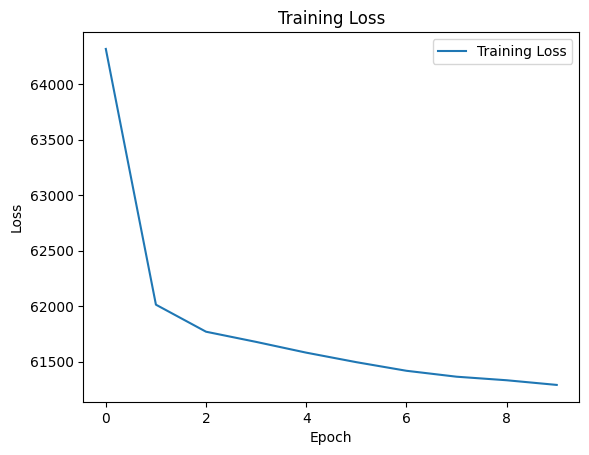

In [8]:
# Plotting the losses
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()